#  Optimizing Machine Performance with Predictive Maintenance Using RandomForestRegressor


## Overview
This project leverages the `RandomForestRegressor` to predict the future efficiency of industrial machines and determine the optimal timing for maintenance. It utilizes the `Volkswagen_OEM_AsiaPacific_2023_SyntheticDataset_withAge.csv`, `VWDataset (1).csv',`which includes comprehensive data on various machine types and their operational histories.

## Dataset Components

### Machine Types
The dataset categorizes machines used in industrial operations into several types, each with specific performance and maintenance profiles:
- **Painting Booth**: Used for painting and coating.
- **Oven**: Employed in heating processes.
- **Torque Tool**: Utilized for tightening and securing.
- **Injection Moulding Machine**: For manufacturing plastic components.
- **Air Compressor**: Converts power into stored energy in pressurized air.
- **AGV (Automated Guided Vehicle)**: Mobile robots for material handling.
- **Testing Calibration Equipment**: Ensures other instruments are accurate.
- **Conveyor**: Facilitates the movement of goods within facilities.
- **Heater and Cooler**: Manages temperature controls.
- **Press**: Shapes or compresses materials.
- **Milling**: Machines used for machining tasks.

### Performance Metrics
- **Machine ID**: Unique identifier for tracking.
- **Buying Date**: Establishes the machine's age and potential wear.
- **Factory Location**: Influences maintenance due to environmental factors.
- **Operational Status**: Indicates whether machines are operational, under maintenance, or out of service.
- **Machine Age**: Derived from the buying date, important for predicting maintenance needs.
- **Efficiency Score**: Historical efficiency data used to predict future performance.

## Model Application

### Predictive Analysis
- **Predict Future Efficiency**: Trains on historical data to forecast performance levels and predict when machines will require maintenance.
- **Determine Maintenance Needs**: Identifies when machines are likely to fail or need maintenance, allowing for proactive scheduling.
- **Visualization**: Includes plots showing the efficiency trends and the impact of maintenance activities.

## Conclusion
By analyzing detailed machine data, this model helps optimize maintenance schedules, thereby enhancing machine performance, extending their lifespan, and reducing operational costs. This approach not only boosts individual machine efficiency but also improves overall factory productivity and reliability.


Mean Squared Error: 4.4137644967397016e-27


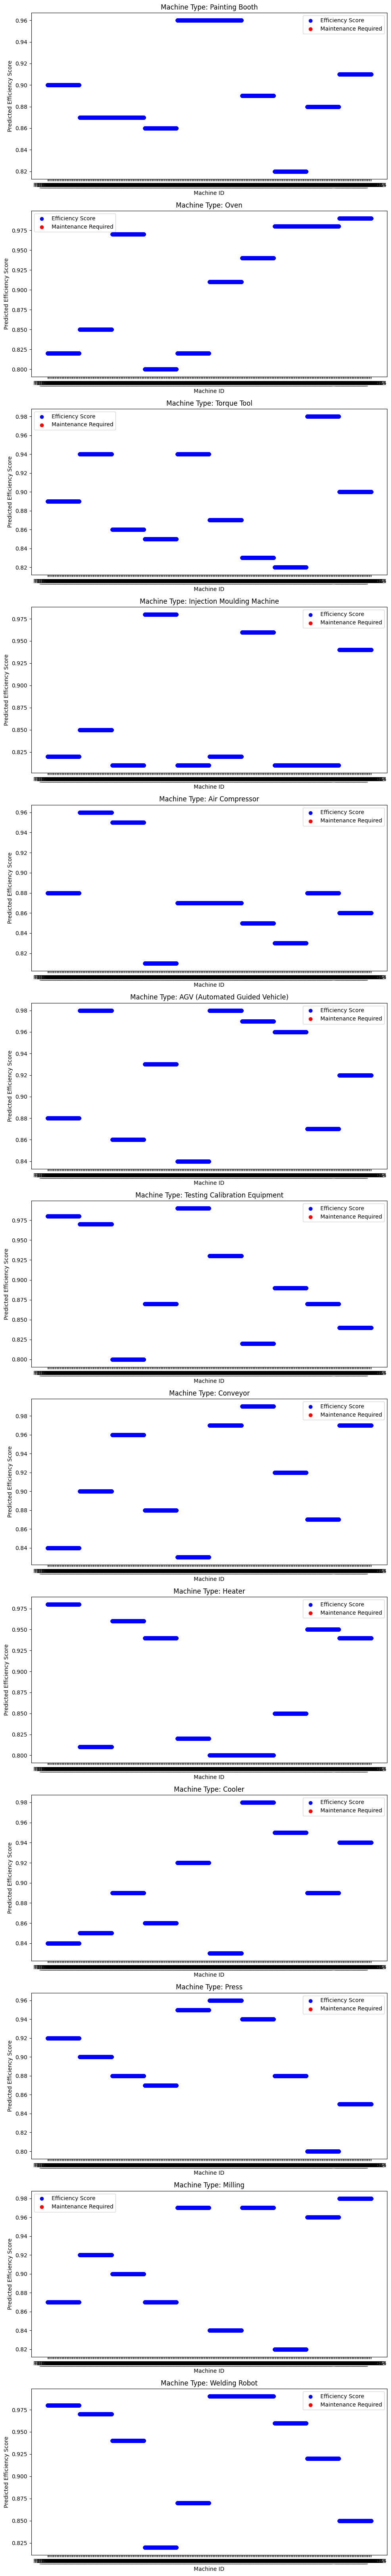

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/kaggle/input/vwdataset/VWDataset (1).csv')

# Ensure 'Buying_Date' is in datetime format
df['Buying_Date'] = pd.to_datetime(df['Buying_Date'])

# Calculate age in years as of now
df['Machine_Age_Years'] = (datetime.now() - df['Buying_Date']).dt.days / 365.25

# Calculate initial efficiency score
df['Initial_Efficiency_Score'] = df['Machine_Age_Years'].apply(lambda x: round(max(0.6, 1.0 - x * 0.1), 2))

# Exclude datetime and non-numeric columns for model training
feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in feature_cols if col != 'Efficiency_Score']  # Exclude target column from features

# Add dummy variables for categorical features
df = pd.get_dummies(df, columns=['Factory_Location', 'Season', 'Operational_Status'])

# Select features for the model
X = df[feature_cols]
y = df['Efficiency_Score']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Predicting for the entire dataset to add 'Predicted_Efficiency_Score' to df
df['Predicted_Efficiency_Score'] = model.predict(df[feature_cols])

# Determine machines needing maintenance
df['Maintenance_Required'] = df['Predicted_Efficiency_Score'].apply(lambda x: 'Yes' if x <= 0.7 else 'No')

# Plotting
unique_machine_types = df['Machine_Type'].unique()
fig, axes = plt.subplots(len(unique_machine_types), 1, figsize=(10, 5 * len(unique_machine_types)))

if len(unique_machine_types) == 1:
    axes = [axes]

for i, machine_type in enumerate(unique_machine_types):
    temp_df = df[df['Machine_Type'] == machine_type]
    axes[i].scatter(temp_df['Machine_ID'], temp_df['Predicted_Efficiency_Score'], color='b', label='Efficiency Score')
    maintenance_df = temp_df[temp_df['Maintenance_Required'] == 'Yes']
    axes[i].scatter(maintenance_df['Machine_ID'], maintenance_df['Predicted_Efficiency_Score'], color='r', label='Maintenance Required')
    axes[i].set_title(f'Machine Type: {machine_type}')
    axes[i].set_xlabel('Machine ID')
    axes[i].set_ylabel('Predicted Efficiency Score')
    axes[i].legend()

plt.tight_layout()
plt.show()


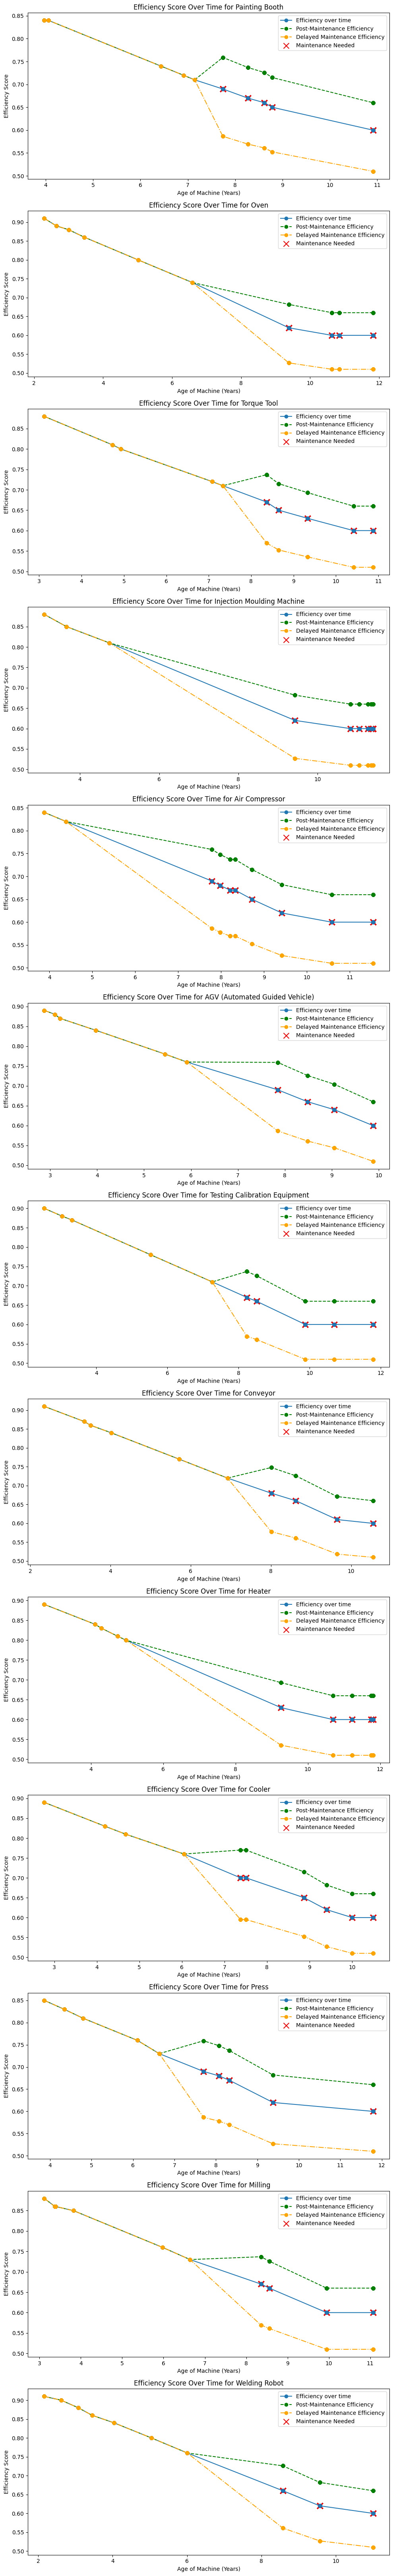

In [26]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/kaggle/input/vwdataset/VWDataset (1).csv')

# Ensure 'Buying_Date' is in datetime format
df['Buying_Date'] = pd.to_datetime(df['Buying_Date'])

# Calculate age in years as of now
df['Machine_Age_Years'] = (datetime.now() - df['Buying_Date']).dt.days / 365.25

# Calculate initial efficiency score based on age
df['Initial_Efficiency_Score'] = df['Machine_Age_Years'].apply(lambda x: round(max(0.6, 1.0 - x * 0.04), 2))

# Assuming a simple model for current efficiency (replace this with actual efficiency data if available)
df['Current_Efficiency_Score'] = df['Initial_Efficiency_Score']

# Set a maintenance threshold for efficiency score
maintenance_threshold = 0.7
df['Maintenance_Needed'] = df['Current_Efficiency_Score'] <= maintenance_threshold

# Simulate efficiency improvement after maintenance
improvement_factor = 0.1  # 10% efficiency improvement
df['Post_Maintenance_Efficiency'] = df.apply(
    lambda row: row['Current_Efficiency_Score'] * (1 + improvement_factor) if row['Maintenance_Needed'] else row['Current_Efficiency_Score'],
    axis=1
)

# Simulate further efficiency decline if maintenance is delayed
decline_factor = 0.15  # 15% additional efficiency decline
df['Delayed_Maintenance_Efficiency'] = df.apply(
    lambda row: row['Current_Efficiency_Score'] * (1 - decline_factor) if row['Maintenance_Needed'] else row['Current_Efficiency_Score'],
    axis=1
)

# Group data by Machine_Type and plot efficiency over time
unique_machine_types = df['Machine_Type'].unique()
fig, axes = plt.subplots(len(unique_machine_types), 1, figsize=(10, 5 * len(unique_machine_types)), squeeze=False)

for i, machine_type in enumerate(unique_machine_types):
    ax = axes[i, 0]
    type_df = df[df['Machine_Type'] == machine_type].sort_values(by='Machine_Age_Years')
    
    # Plot current efficiency over time
    ax.plot(type_df['Machine_Age_Years'], type_df['Current_Efficiency_Score'], marker='o', linestyle='-', label='Efficiency over time')
    
    # Plot post-maintenance efficiency improvement
    ax.plot(type_df['Machine_Age_Years'], type_df['Post_Maintenance_Efficiency'], marker='o', linestyle='--', color='green', label='Post-Maintenance Efficiency')
    
    # Plot efficiency with delayed maintenance
    ax.plot(type_df['Machine_Age_Years'], type_df['Delayed_Maintenance_Efficiency'], marker='o', linestyle='-.', color='orange', label='Delayed Maintenance Efficiency')

    # Highlight maintenance points
    maintenance_df = type_df[type_df['Maintenance_Needed']]
    ax.scatter(maintenance_df['Machine_Age_Years'], maintenance_df['Current_Efficiency_Score'], color='red', marker='x', s=100, label='Maintenance Needed')

    ax.set_title(f'Efficiency Score Over Time for {machine_type}')
    ax.set_xlabel('Age of Machine (Years)')
    ax.set_ylabel('Efficiency Score')
    ax.legend()

plt.tight_layout()
plt.show()
